# Vocabulary casting

Consider this SPA model:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import nengo
import numpy as np

import nengo_spa as spa

# Change the seed of this RNG to change the vocabulary
rng = np.random.RandomState(0)

In [2]:
d = 16
vocab1 = spa.Vocabulary(16, pointer_gen=rng)
vocab2 = spa.Vocabulary(16, pointer_gen=rng)

with spa.Network() as model:
    state1 = spa.State(vocab=vocab1)
    state2 = spa.State(vocab=vocab2)

In this model `state1` and `state2` are assigned to different and independent
vocabularies. This means we cannot simply connect `state1` and `state2` in SPA actions
because Nengo cannot know how to transform ("cast") from one vocabulary to the other
vocabulary. We are required to tell Nengo how we want to do this cast. Currently there
two methods implemented.

## Reinterpretation

The `reinterpret` method can only be used with vocabularies of the same dimension. It
will not change the semantic pointer passed from one state to the other, but changes it
interpretation.

In [3]:
d1 = 16
d2 = 16
vocab1 = spa.Vocabulary(d1, pointer_gen=rng)
vocab1.populate("A")
vocab2 = spa.Vocabulary(d2, pointer_gen=rng)
vocab2.populate("A")

with spa.Network() as model:
    state1 = spa.State(vocab=vocab1)
    state2 = spa.State(vocab=vocab2)
    spa.sym.A >> state1
    spa.reinterpret(state1) >> state2

    p = nengo.Probe(state2.output, synapse=0.03)

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

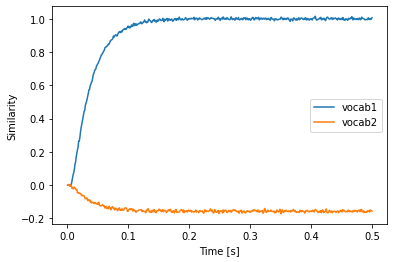

In [5]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], vocab1), label="vocab1")
plt.plot(sim.trange(), spa.similarity(sim.data[p], vocab2), label="vocab2")
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(loc="best")

## Translation

Translation matches the vocabularies by the keys and uses the outer product of the
corresponding semantic pointers as a transformation matrix to transform vectors from one
vocabulary to another vocabulary. This works also with vocabularies of differing
dimensionality.

In [6]:
d1 = 16
d2 = 32
vocab1 = spa.Vocabulary(d1, pointer_gen=rng)
vocab1.populate("A")
vocab2 = spa.Vocabulary(d2, pointer_gen=rng)
vocab2.populate("A")

with spa.Network() as model:
    state1 = spa.State(vocab=vocab1)
    state2 = spa.State(vocab=vocab2)
    spa.sym.A >> state1
    spa.translate(state1, vocab2) >> state2

    p = nengo.Probe(state2.output, synapse=0.03)

In [7]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

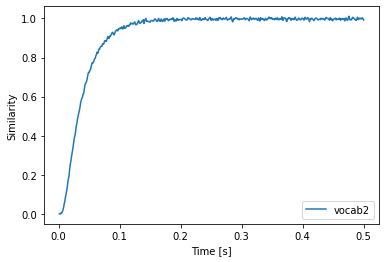

In [8]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], vocab2), label="vocab2")
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(loc="best")

## Further options

Both `translate` and `reinterpret` try to infer the target vocabularies, but this might
not be possible in all cases. Thus, both functions take an additional argument which can
either be a SPA module or a vocabulary. If it is a SPA module (e.g., `translate(state1,
state2)`), that module's vocabulary will be used as target vocabulary. If it is a
vocabulary, the given vocabulary will be used as target vocabulary (e.g.,
`translate(state1, vocab2)`). Note that in the latter case a dictionary specifying the
names and vocabularies has to be passed as the `vocabs` argument to the `Actions`
instance like so: `Actions('translate(state1, vocab2) -> state2')`.

Note that you can give the second argument to `translate` and `reinterpret` also as a
keyword argument (e.g., `translate(state1, vocab=state2)`.